# 1- Limpieza y creación de features

In [5]:
import pandas as pd

df = pd.read_csv("../data/comentarios_analizados.csv")

In [6]:
df.drop({"Unnamed: 0", "TOXICITY"}, axis=1, inplace=True)
df.rename({"text_x":"text"}, axis=1, inplace=True)

df.drop_duplicates(subset ='text', keep = False, inplace = True)
df = df.loc[df.canal != "Nimu"]


In [7]:
df.canal.value_counts()

NICO VILLA                313198
Romi                      212981
PassThor                  209330
Tincho Ruiz                90509
maritobaracus              73837
FFran Gomez                43708
Hecatombe Producciones     41661
AleVera Oficial            37155
Guille Aquino              32719
Rodriguez Galati           31112
Melina Vallejos            18171
SimpDNimu                    686
Name: canal, dtype: int64

Binarizo todo de acuerdo al threshold

In [8]:
toxicity_fields = [
    "toxicity",
    "THREAT_EXPERIMENTAL",
    "IDENTITY_ATTACK_EXPERIMENTAL",
    "INSULT_EXPERIMENTAL",
    "PROFANITY_EXPERIMENTAL",
    "SEVERE_TOXICITY",
]

engagement_fields = [
    'replyCount', 'likeCount', 'likes_video', 'vistas_video', 'cantidad_comentarios'
]

threshold = 0.8

df.loc[:, toxicity_fields] = df.loc[:, toxicity_fields] > threshold

Hasta acá, df es de comentarios, ahora con los valores binarizados.

Queremos un df por video 

Tomo la suma en el caso de los replyCounts y likeCounts (son a nivel comentario) y el primero para cada video

**CHEQUEAR ESTO!**

In [9]:
df_video = df.groupby("videoId").agg({
    **{k:"mean" for k in toxicity_fields},
    **{k:"sum" for k in ['replyCount', 'likeCount']},
    **{k:"first" for k in ['likes_video', 'vistas_video', 'cantidad_comentarios', 'canal']}
})

In [10]:
df_video["canal"].unique()

array(['Rodriguez Galati', 'NICO VILLA', 'maritobaracus', 'FFran Gomez',
       'AleVera Oficial', 'Tincho Ruiz', 'Romi', 'PassThor',
       'Hecatombe Producciones', 'Melina Vallejos', 'SimpDNimu',
       'Guille Aquino'], dtype=object)

In [11]:
youtubers = df_video["canal"].unique()
zscore_fields = [
    'toxicity', 'SEVERE_TOXICITY' ,'replyCount', 'likeCount', 'likes_video', 'vistas_video', 'cantidad_comentarios'
]

for field in zscore_fields:
    zscore_name = "z_" + field
    print(field)
    for youtuber in youtubers:
        values = df_video.loc[df_video["canal"] == youtuber, field]
        mean = values.mean()
        std = values.std()
        df_video.loc[df_video["canal"] == youtuber, zscore_name] = ((values - mean) / std).values

    


toxicity
SEVERE_TOXICITY
replyCount
likeCount
likes_video
vistas_video
cantidad_comentarios


In [13]:
df_video.insert(1, "z_toxicity", df_video.pop("z_toxicity"))
df_video.insert(2, "z_SEVERE_TOXICITY", df_video.pop("z_SEVERE_TOXICITY"))

<AxesSubplot:>

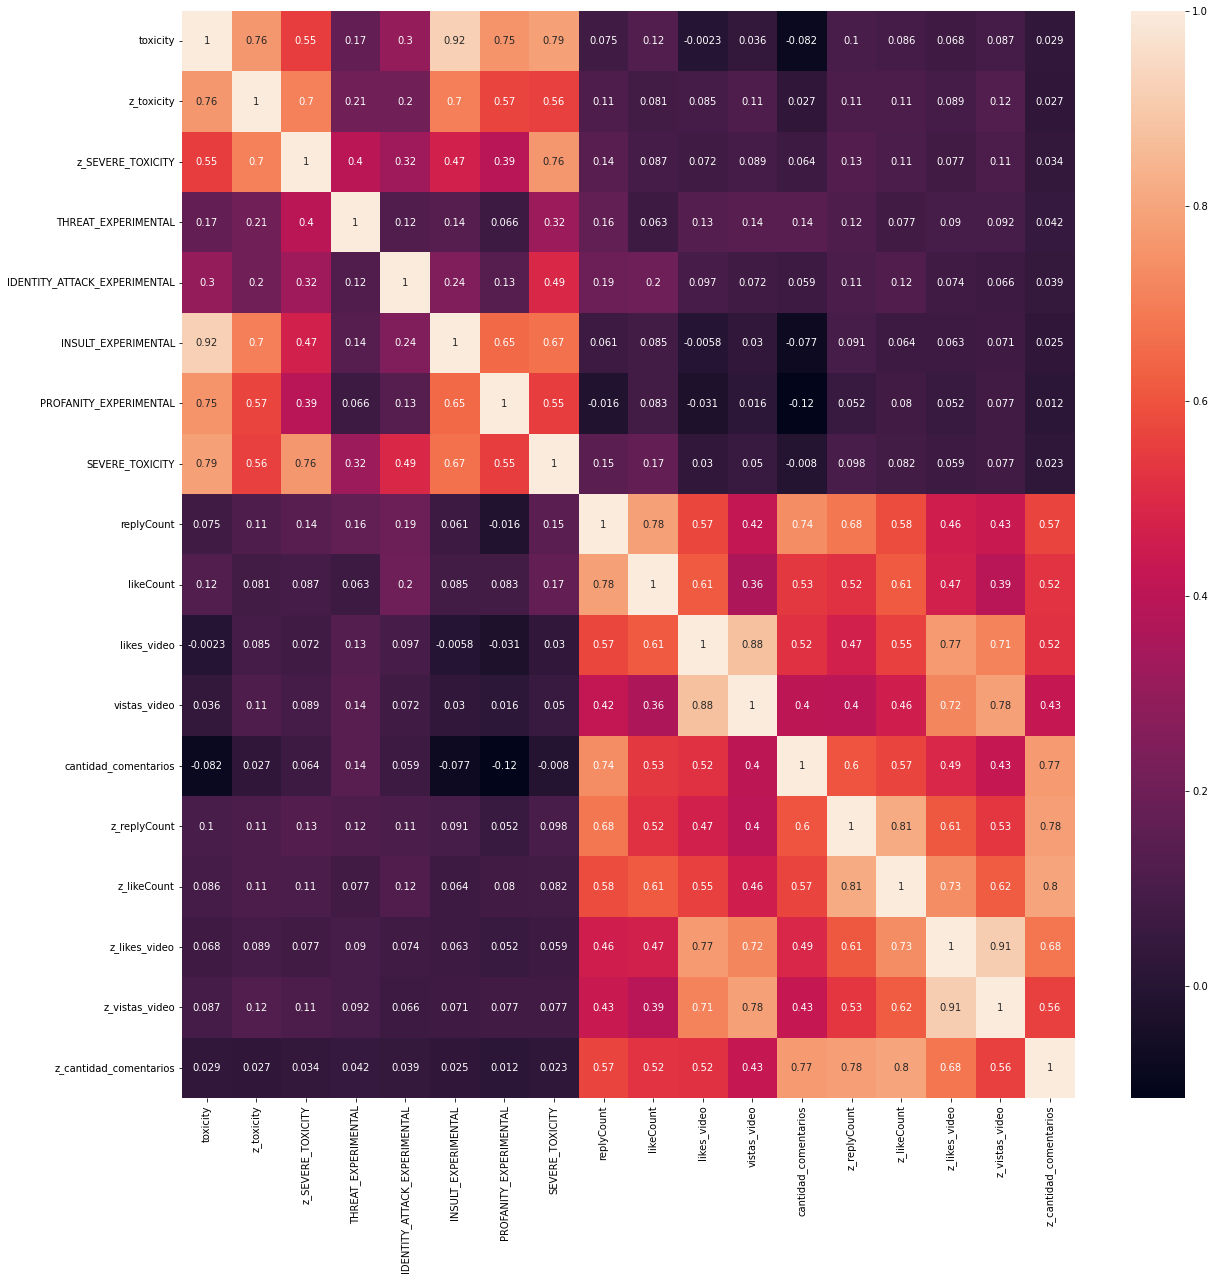

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns


plt.figure(figsize=(20,20))

sns.heatmap(data=df_video.corr(), annot=True)

## Cómicos

<AxesSubplot:>

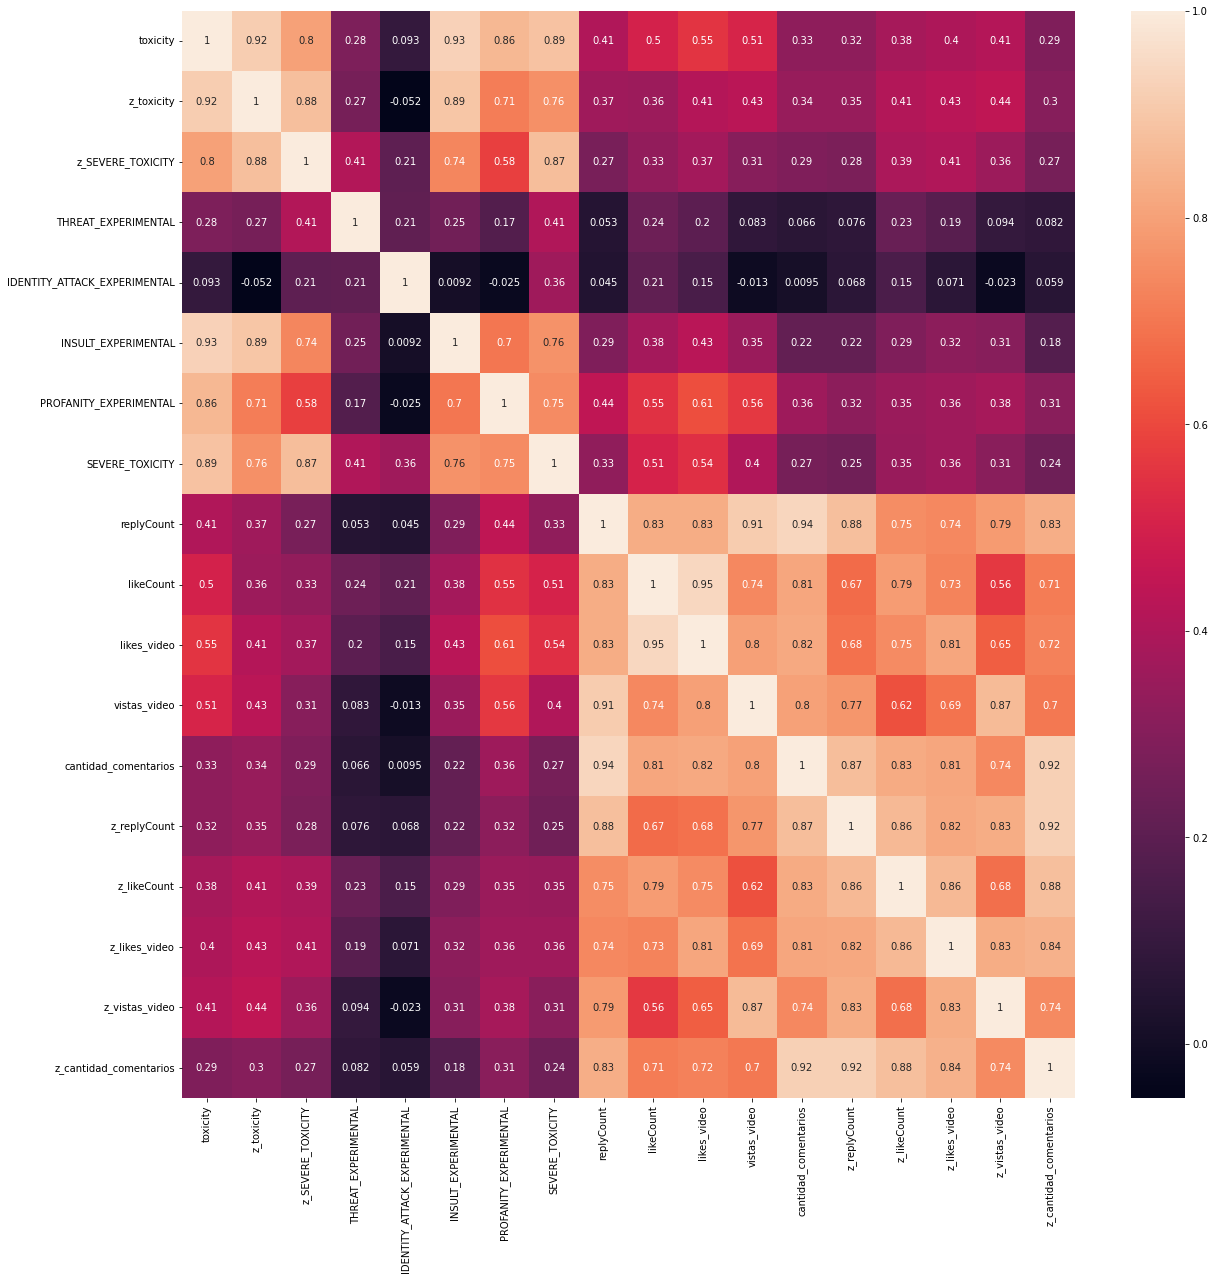

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
comicos = ["maritobaracus", 'AleVera Oficial', "Nimu"]

plt.figure(figsize=(20,20))

df_video_comicos = df_video.loc[df_video["canal"].isin(comicos)]

sns.heatmap(data=df_video_comicos.corr(), annot=True)

<AxesSubplot:>

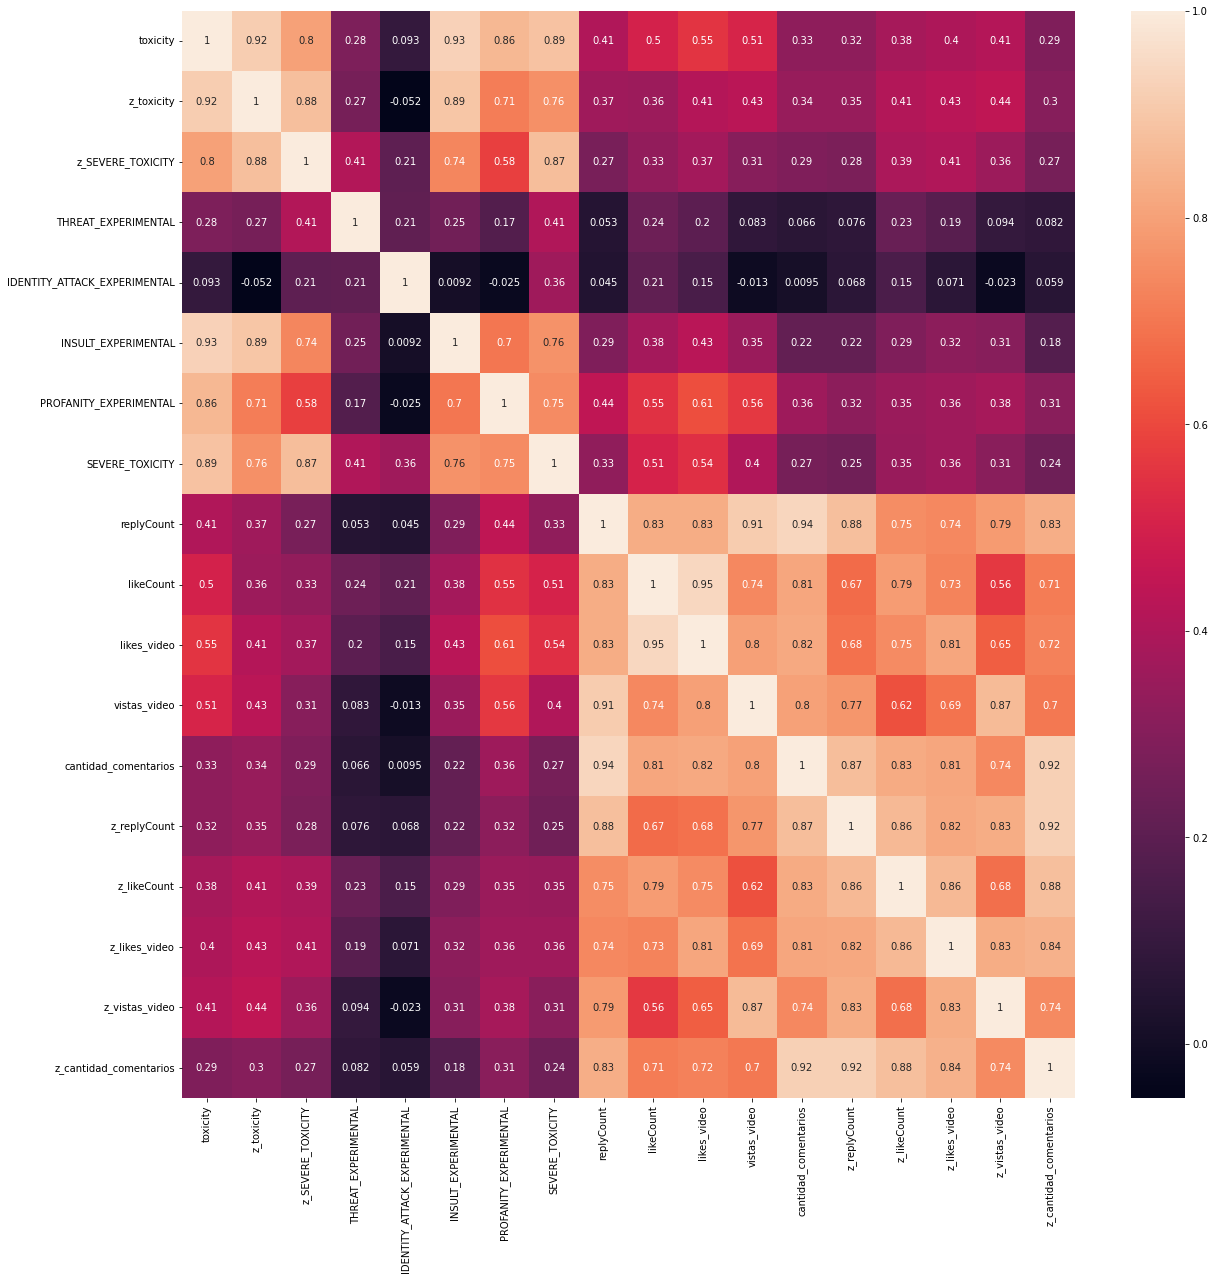

In [16]:

comicos = ["maritobaracus", 'AleVera Oficial']

plt.figure(figsize=(20,20))

df_video_comicos = df_video.loc[df_video["canal"].isin(comicos)]

sns.heatmap(data=df_video_comicos.corr(), annot=True)

In [17]:
from scipy.stats import pearsonr
import pandas as pd

def calculate_pvalues(df):
    df = df.dropna()._get_numeric_data()
    dfcols = pd.DataFrame(columns=df.columns)
    pvalues = dfcols.transpose().join(dfcols, how='outer')
    for r in df.columns:
        for c in df.columns:
            pvalues[r][c] = round(pearsonr(df[r], df[c])[1], 6)
    return pvalues.astype(float)

<AxesSubplot:>

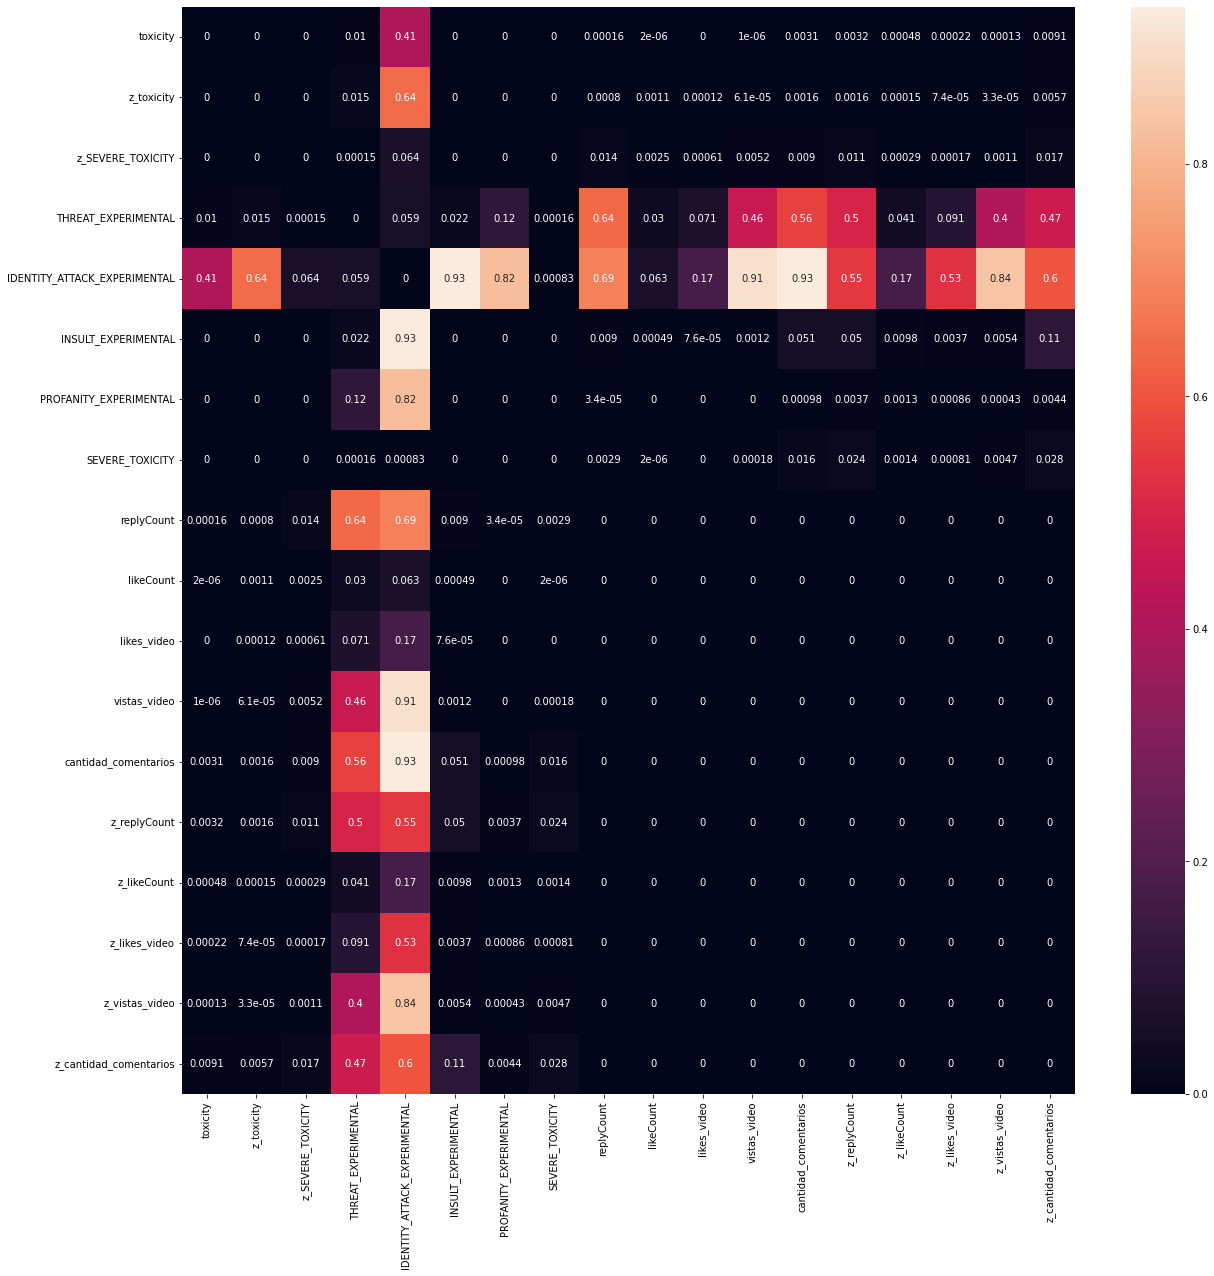

In [18]:

plt.figure(figsize=(20,20))


sns.heatmap(data=calculate_pvalues(df_video_comicos), annot=True)

## Efectos fijos

Agrego variables dummy para los efectos fijos por autor

In [84]:
data = df_video.copy()

autores = data.canal.value_counts().keys()

dummy_columns = [f"dummy_{canal}" for canal in autores]

for autor in autores:
    col_name = f"dummy_{autor}"
    data[col_name] = data.canal.apply(lambda x: 1 if x == autor else 0)

In [85]:
assert all(data.loc[:, dummy_columns].sum(axis=1) == 1)

In [96]:

import seaborn as sns
import matplotlib.pyplot as plt


toxicity_fields = [
    "toxicity",
    "THREAT_EXPERIMENTAL",
    "IDENTITY_ATTACK_EXPERIMENTAL",
    "INSULT_EXPERIMENTAL",
    "PROFANITY_EXPERIMENTAL",
    "SEVERE_TOXICITY",
]

engagement_fields = [
    'replyCount', 'likeCount', 'likes_video', 'vistas_video', 'cantidad_comentarios'
]

"""
for toxicity_field in toxicity_fields:
    for engagement_field in engagement_fields:
        plt.figure(figsize=(5,5))
        plt.semilogy()
        sns.scatterplot(y=engagement_field, x=toxicity_field, data=data, hue="canal")
"""

'\nfor toxicity_field in toxicity_fields:\n    for engagement_field in engagement_fields:\n        plt.figure(figsize=(5,5))\n        plt.semilogy()\n        sns.scatterplot(y=engagement_field, x=toxicity_field, data=data, hue="canal")\n'

Sin efectos fijos y sin log

In [110]:
import numpy as np
import statsmodels.regression.linear_model as sm


for toxicity_field in toxicity_fields:
    print("=" * 100)
    print(toxicity_field, "\n"*2)

    for engagement_field in engagement_fields:
        #print(f"log({engagement_field}) ~ {toxicity_field}")
        model = sm.OLS(data[engagement_field], data[toxicity_field])
        results = model.fit()

        print(f"{engagement_field:<25} slope {results.params.values[0]:3.3f} (pval = {results.pvalues.values[0]:.4f}, r2 = {results.rsquared:.4f})")
        

toxicity 


replyCount                slope 7353.756 (pval = 0.0000, r2 = 0.2457)
likeCount                 slope 218001.931 (pval = 0.0000, r2 = 0.2343)
likes_video               slope 822279.143 (pval = 0.0000, r2 = 0.3309)
vistas_video              slope 10875681.949 (pval = 0.0000, r2 = 0.2850)
cantidad_comentarios      slope 37307.925 (pval = 0.0000, r2 = 0.2132)
THREAT_EXPERIMENTAL 


replyCount                slope 12959.934 (pval = 0.0000, r2 = 0.2985)
likeCount                 slope 330115.296 (pval = 0.0000, r2 = 0.2102)
likes_video               slope 1462323.205 (pval = 0.0000, r2 = 0.4093)
vistas_video              slope 19234141.111 (pval = 0.0000, r2 = 0.3487)
cantidad_comentarios      slope 74359.187 (pval = 0.0000, r2 = 0.3313)
IDENTITY_ATTACK_EXPERIMENTAL 


replyCount                slope 15095.280 (pval = 0.0000, r2 = 0.2388)
likeCount                 slope 437884.124 (pval = 0.0000, r2 = 0.2180)
likes_video               slope 1525248.638 (pval = 0.0000, r2 = 0.262

Sin efectos fijos (con log engagement)

In [111]:
import numpy as np
import statsmodels.regression.linear_model as sm


for toxicity_field in toxicity_fields:
    print("=" * 100)
    print(toxicity_field, "\n"*2)

    for engagement_field in engagement_fields:
        #print(f"log({engagement_field}) ~ {toxicity_field}")
        model = sm.OLS(np.log(data[engagement_field]), data[toxicity_field])
        results = model.fit()

        print(f"{engagement_field:<25} slope {results.params.values[0]:3.3f} (pval = {results.pvalues.values[0]:.4f}, r2 = {results.rsquared:.4f})")
        

toxicity 


replyCount                slope 124.519 (pval = 0.0000, r2 = 0.5786)
likeCount                 slope 204.618 (pval = 0.0000, r2 = 0.6036)
likes_video               slope 249.888 (pval = 0.0000, r2 = 0.5985)
vistas_video              slope 313.757 (pval = 0.0000, r2 = 0.6068)
cantidad_comentarios      slope 169.246 (pval = 0.0000, r2 = 0.5744)
THREAT_EXPERIMENTAL 


replyCount                slope 209.525 (pval = 0.0000, r2 = 0.6408)
likeCount                 slope 334.110 (pval = 0.0000, r2 = 0.6295)
likes_video               slope 412.906 (pval = 0.0000, r2 = 0.6392)
vistas_video              slope 516.306 (pval = 0.0000, r2 = 0.6428)
cantidad_comentarios      slope 285.555 (pval = 0.0000, r2 = 0.6395)
IDENTITY_ATTACK_EXPERIMENTAL 


replyCount                slope 222.779 (pval = 0.0000, r2 = 0.4272)
likeCount                 slope 357.849 (pval = 0.0000, r2 = 0.4259)
likes_video               slope 426.340 (pval = 0.0000, r2 = 0.4018)
vistas_video              slope 529.

Con efectos fijos

In [98]:
import numpy as np


toxicity_fields = [
    "toxicity",
    "THREAT_EXPERIMENTAL",
    "IDENTITY_ATTACK_EXPERIMENTAL",
    "INSULT_EXPERIMENTAL",
    "PROFANITY_EXPERIMENTAL",
    "SEVERE_TOXICITY",
]

engagement_fields = [
    'replyCount', 'likeCount', 'likes_video', 'vistas_video', 'cantidad_comentarios'
]

for toxicity_field in toxicity_fields:
    print("=" * 100)
    print(toxicity_field, "\n"*2)

    for engagement_field in engagement_fields:
        model = sm.OLS(np.log(data[engagement_field]), data[[toxicity_field] + dummy_columns])
        results = model.fit()

        print(f"{engagement_field:<30} = {results.params.values[0]:.6f} (pval = {results.pvalues.values[0]:.4f}, r2 = {results.rsquared:.4f})")
        

toxicity 


replyCount                     = 7.054894 (pval = 0.0001, r2 = 0.4643)
likeCount                      = 5.069661 (pval = 0.0181, r2 = 0.4530)
likes_video                    = 3.367475 (pval = 0.0337, r2 = 0.3478)
vistas_video                   = 5.638282 (pval = 0.0010, r2 = 0.2685)
cantidad_comentarios           = 2.738511 (pval = 0.0872, r2 = 0.4773)
THREAT_EXPERIMENTAL 


replyCount                     = 10.462030 (pval = 0.0002, r2 = 0.4641)
likeCount                      = 9.137292 (pval = 0.0046, r2 = 0.4547)
likes_video                    = 4.733279 (pval = 0.0472, r2 = 0.3473)
vistas_video                   = 5.959068 (pval = 0.0212, r2 = 0.2635)
cantidad_comentarios           = 7.739017 (pval = 0.0013, r2 = 0.4821)
IDENTITY_ATTACK_EXPERIMENTAL 


replyCount                     = 12.160961 (pval = 0.0001, r2 = 0.4654)
likeCount                      = 13.948028 (pval = 0.0001, r2 = 0.4600)
likes_video                    = 7.726566 (pval = 0.0029, r2 = 0.3513)
vistas_